Equation: - div(del u ) = f in [0,pi] x [0,1]

equivalent: -uxx-uyy = f


u(x,y) = g on boundary

u(x,y) =sin(cx)sin(cy)

ux  = c*cos(cx)sin(cy), uxx = -c^2sin(cx)sin(cy)

uy = c*sin(cx)cos(cy), uyy = -c^2sin(cx)sin(cy)

uxx+uyy = -2c^2sin(cx)sin(cy) so f should be 2c^2sin(cx)sin(cy)

In [104]:
import tensorflow as tf
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from pyDOE import lhs
import pandas as pd
import math


In [105]:
PINN=True #toggle between PINN and plain NN

In [106]:
#generates exact data
data  = np.zeros([101, 101]) 
x = np.zeros([101])
y = np.zeros([101])
pi = math.pi
const = pi
for i in range(101):
    x[i] = i/100
    for j in range(101):
        if i==0:
            y[j]=j/100
        data[i,j] = (math.sin(x[i]*const))*math.sin(y[j]*const)
data = data.T
#maybe don't need transpose, but the burgers has it

In [107]:
#makes a list of every x y combination and a list of the values
X, Y = np.meshgrid(x,y) 
X_star=np.hstack((X.flatten()[:,None],Y.flatten()[:,None])) 
u_star = data.flatten()[:,None] 
print(X_star.shape)
print(u_star.shape)

(10201, 2)
(10201, 1)


In [108]:
xx1=np.hstack((X[0:1,:].T,Y[0:1,:].T))  # coords for initial boundary condition  y=0
xx2=np.hstack((X[:,0:1],Y[:,0:1]))      # coords for boundary condition for x=0 
xx3=np.hstack((X[:,-1:],Y[:,-1:]))      # coords for boundary condition for x=1
xx4=np.hstack((X[-1:,:].T, Y[-1:,:].T)) #coords for boundary condition y=1

uu1 = data[0:1,:].T #data for y=0, this transpose is also present in the other code
uu2 = data[:,0:1] #data for x =0
uu3 = data[:,-1:] #data for x=pi, should technically be all 0, but the error in the pi causes it to be just very small
uu4 = data[-1:,:].T #data for y=1
actual_outputs_1  = data[25:26,:].T
actual_outputs_2  = data[50:51,:].T
actual_outputs_3  = data[75:76,:].T

In [109]:
lb = X_star.min(axis=0)    # (1,2)   [-1 0]
ub = X_star.max(axis=0)    # (1,2)   [1 0.99]
no_of_interior_points=8000
no_of_collocation_points=100

X_u_train = np.vstack([xx1, xx2, xx3, xx4])                           #  stacking up all data related to boundary conditions 
X_f_train = lb + (ub-lb)*lhs(2, no_of_interior_points)           # lhs is used to generate random sample of points. 2 is no of variables(x,t).
u_train = np.vstack([uu1, uu2, uu3, uu4])                             #  values correspoing to X_u_train

In [110]:
idx = np.random.choice(X_u_train.shape[0], no_of_collocation_points , replace=False) # random sample of collocation points from boundary coords
X_u_train = X_u_train[idx, :]                                                        # Those collocation points chosen from boundary conditions data
u_train = u_train[idx,:]     # Output corresponding to collocation points

In [111]:
# subscript u denotes collocation/boundary points and subscript f denotes interior points
x_u = X_u_train[:,0:1]       #Separating x,t from X_u_train
y_u = X_u_train[:,1:2]
x_f = X_f_train [:,0:1]
y_f = X_f_train [:,1:2]

In [112]:
x_u_tf=tf.Variable(x_u)       #Converting to tensor variable. Essential for calculating gradients later on.
y_u_tf=tf.Variable(y_u)
x_f_tf=tf.Variable(x_f)
y_f_tf=tf.Variable(y_f)
X_all_train = np.vstack((X_f_train, X_u_train))     #puts together boundary points and interior points
X_all_train_tf=tf.Variable(X_all_train)


In [113]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input
def get_model():
  model=Sequential([
                    Dense(20,activation='tanh',kernel_initializer=tf.keras.initializers.GlorotNormal(),input_shape=(2,),name='H1')
  ])
  
  for i in range(6):
    model.add(Dense(20,activation='tanh',kernel_initializer=tf.keras.initializers.GlorotNormal(),name='H'+str(i+2)))

  model.add(Dense(1,name='output_layer'))

  return model

In [114]:
model=get_model()
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 H1 (Dense)                  (None, 20)                60        
                                                                 
 H2 (Dense)                  (None, 20)                420       
                                                                 
 H3 (Dense)                  (None, 20)                420       
                                                                 
 H4 (Dense)                  (None, 20)                420       
                                                                 
 H5 (Dense)                  (None, 20)                420       
                                                                 
 H6 (Dense)                  (None, 20)                420       
                                                                 
 H7 (Dense)                  (None, 20)               

In [115]:
def f_star(inmatrix):
    xvalues = inmatrix[:,0]
    yvalues = inmatrix[:, 1]
    #f should be 2c^2sin(cx)sin(cy) for this problem
    
    pointnum, varnum = X_all_train_tf.shape
    output = np.zeros([pointnum]) 
    for i in range(pointnum):
        output[i] =2*const*const*math.sin(const*xvalues[i])*np.sin(const*yvalues[i])
        
    #output= 2*const*const*np.multiply(np.sin(const*xvalues), np.sin(const*yvalues))
    return output

In [116]:
#function for calculating loss wrt to interior points
def interior_loss():
    if PINN == True:
        with tf.GradientTape() as tape:
            tape.watch(X_all_train_tf)
            with tf.GradientTape() as tape2:
                u_predicted=model(X_all_train_tf)
            grad=tape2.gradient(u_predicted,X_all_train_tf)
            du_dx=grad[:, 0]
            du_dy=grad[:, 1]
        j = tape.gradient(grad, X_all_train_tf)
        d2u_dx2 = j[:,0]
        d2u_dy2 = j[:,1]
        u_predicted=tf.cast(u_predicted, dtype=tf.float64)
        xlength = int(len(X_all_train_tf[:,1]))
        d2u_dx2=tf.reshape(d2u_dx2, [xlength,1])
        d2u_dy2=tf.reshape(d2u_dy2, [xlength,1])
        d2u_dx2=tf.cast(d2u_dx2, dtype=tf.float64)
        d2u_dy2=tf.cast(d2u_dy2, dtype=tf.float64)
        laplacian= d2u_dx2+d2u_dy2  
        f = f_star(X_all_train)
        f=f+laplacian #want to minimize to 0
        f=tf.math.reduce_mean(tf.math.square(f)) #squares elementwise and finds average 
    if PINN==False:
        f=0
    return f

In [117]:
"""
LBFG-S, which is second order optimizer, has been used to update the weights and biases because conventional first order optimizers Adam, Gradient descent and RMSprop 
are slow to converge.LBFG-S is not available by default in Tensorflow 2.0 and hence a function from Tensorflow Probability has been used. This has not been coded by me
except for a minor addition to loss function(check the loss_value variable). Please refer to the link below to get a better idea.

https://gist.github.com/piyueh/712ec7d4540489aad2dcfb80f9a54993

"""
import numpy
import tensorflow as tf
import tensorflow_probability as tfp
from matplotlib import pyplot

def function_factory(model, loss, train_x, train_y):
    """A factory to create a function required by tfp.optimizer.lbfgs_minimize.
    Args:
        model [in]: an instance of `tf.keras.Model` or its subclasses.
        loss [in]: a function with signature loss_value = loss(pred_y, true_y).
        train_x [in]: the input part of training data.
        train_y [in]: the output part of training data.
    Returns:
        A function that has a signature of:
            loss_value, gradients = f(model_parameters).
    """

    # obtain the shapes of all trainable parameters in the model
    shapes = tf.shape_n(model.trainable_variables)
    n_tensors = len(shapes)

    # we'll use tf.dynamic_stitch and tf.dynamic_partition later, so we need to
    # prepare required information first
    count = 0
    idx = [] # stitch indices
    part = [] # partition indices

    for i, shape in enumerate(shapes):
        n = numpy.product(shape)
        idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32), shape))
        part.extend([i]*n)
        count += n

    part = tf.constant(part)

    @tf.function
    def assign_new_model_parameters(params_1d):
        """A function updating the model's parameters with a 1D tf.Tensor.
        Args:
            params_1d [in]: a 1D tf.Tensor representing the model's trainable parameters.
        """

        params = tf.dynamic_partition(params_1d, part, n_tensors)
        for i, (shape, param) in enumerate(zip(shapes, params)):
            model.trainable_variables[i].assign(tf.reshape(param, shape))

    # now create a function that will be returned by this factory
    @tf.function
    def f(params_1d):
        """A function that can be used by tfp.optimizer.lbfgs_minimize.
        This function is created by function_factory.
        Args:
           params_1d [in]: a 1D tf.Tensor.
        Returns:
            A scalar loss and the gradients w.r.t. the `params_1d`.
        """

        # use GradientTape so that we can calculate the gradient of loss w.r.t. parameters
        with tf.GradientTape() as tape:
            # update the parameters in the model
            assign_new_model_parameters(params_1d)
            # calculate the loss
            loss_value = loss(model(train_x, training=True), train_y)
            int_loss=interior_loss()
            loss_value = tf.cast(loss_value, tf.float64)
            int_loss = tf.cast(int_loss, tf.float64)
            loss_value=loss_value+int_loss


        # calculate gradients and convert to 1D tf.Tensor
        grads = tape.gradient(loss_value, model.trainable_variables)
        grads = tf.dynamic_stitch(idx, grads)

        # print out iteration & loss
        f.iter.assign_add(1)
        tf.print("Iter:", f.iter, "loss:", loss_value)

        # store loss value so we can retrieve later
        tf.py_function(f.history.append, inp=[loss_value], Tout=[])

        return loss_value, grads

    # store these information as members so we can use them outside the scope
    f.iter = tf.Variable(0)
    f.idx = idx
    f.part = part
    f.shapes = shapes
    f.assign_new_model_parameters = assign_new_model_parameters
    f.history = []

    return f


def plot_helper(inputs, outputs, title, fname):

    pyplot.figure(figsize=(8,4))
    pyplot.tricontourf(inputs[:, 1], inputs[:, 0], outputs.flatten(), 100)
    pyplot.scatter(X_u_train[:, 1], X_u_train[:, 0],marker='x',s=100,c='k')
    #pyplot.scatter(X_f_train[:, 1], X_f_train[:, 0],marker='.',s=.1,c='k') # code to turn on the ability to see interior test points
    pyplot.xlabel("y")
    pyplot.ylabel("x")
    pyplot.title(title)
    pyplot.colorbar()
    pyplot.savefig(fname)

In [118]:
tf.keras.backend.set_floatx("float64")
func = function_factory(model, tf.keras.losses.MeanSquaredError() ,X_u_train , u_train)
init_params = tf.dynamic_stitch(func.idx, model.trainable_variables)
results = tfp.optimizer.lbfgs_minimize(value_and_gradients_function=func, initial_position=init_params, max_iterations=1000)

Iter: 1 loss: 98.3690611492122
Iter: 2 loss: 1146476861061544.8
Iter: 3 loss: 5916118804712.2705
Iter: 4 loss: 98.369061132821145
Iter: 5 loss: 59.886121136818055
Iter: 6 loss: 99.284705045540775
Iter: 7 loss: 56.326342220538386
Iter: 8 loss: 65.534453688956162
Iter: 9 loss: 52.439287925659592
Iter: 10 loss: 50.972179676642234
Iter: 11 loss: 84.1058945138902
Iter: 12 loss: 50.971924374668404
Iter: 13 loss: 49.564662690364344
Iter: 14 loss: 46.832048848725314
Iter: 15 loss: 93.388270629530169
Iter: 16 loss: 46.8037923193642
Iter: 17 loss: 45.403095920901677
Iter: 18 loss: 45.104250939883094
Iter: 19 loss: 44.546762605357053
Iter: 20 loss: 44.139575536419123
Iter: 21 loss: 43.926568349452666
Iter: 22 loss: 42.738755292841681
Iter: 23 loss: 51.614866843402687
Iter: 24 loss: 42.509965159764178
Iter: 25 loss: 40.101986100762112
Iter: 26 loss: 56.665292303682591
Iter: 27 loss: 39.522716014641105
Iter: 28 loss: 38.764883569349813
Iter: 29 loss: 38.517167405268282
Iter: 30 loss: 37.49348494680

In [119]:
func.assign_new_model_parameters(results.position)


In [120]:
p=np.vstack([X_f_train,X_u_train])
q=np.vstack([model.predict(X_f_train),model.predict(X_u_train)])[:,0]

4/4 [==============================] - 0s 4ms/step


In [121]:
print(q[7888])
print(p[7888])
np.min(q)

0.05684189677871376
[0.14191122 0.91328608]


-0.08095196932607607

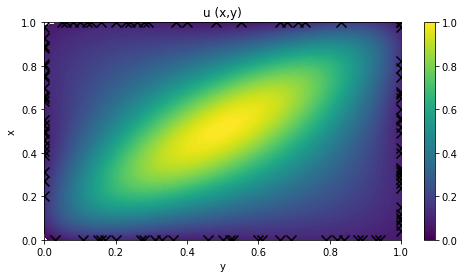

In [122]:
plot_helper(p, q, "u (x,y)", "pred_soln3.pdf")

In [123]:
x_t_0=np.hstack(( X[0:1,:].T, Y[0:1,:].T))
x_t_25=np.hstack(( X[0:1,:].T, Y[25:26,:].T))
x_t_50=np.hstack(( X[0:1,:].T, Y[50:51,:].T))
x_t_75=np.hstack(( X[0:1,:].T, Y[75:76,:].T))

4/4 [==============================] - 0s 7ms/step


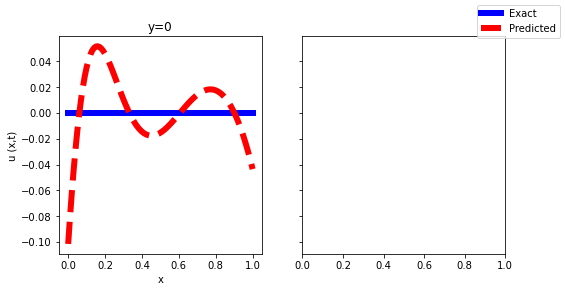

In [124]:
#graphs for given initial value, should be exact
fig, axs = plt.subplots(1, 2, figsize=(8,4) ,sharey=True)

l1,=axs[0].plot(x, uu1,linewidth=6,color='b')
l2,=axs[0].plot(x_t_0[:,0],model.predict(x_t_0),linewidth=6,linestyle='dashed',color='r')
axs[0].set_title('y=0')
axs[0].set_xlabel('x')
axs[0].set_ylabel('u (x,t)')
line_labels = ['Exact','Predicted']

fig.legend(handles=(l1,l2),labels=('Exact','Predicted'),loc='upper right')
pyplot.savefig('graphs4.pdf')

4/4 [==============================] - 0s 3ms/step


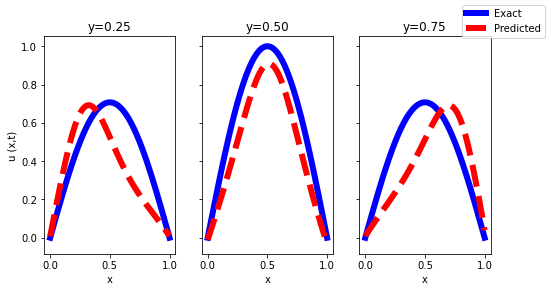

In [125]:
fig, axs = plt.subplots(1, 3, figsize=(8,4) ,sharey=True)

l1,=axs[0].plot(x, actual_outputs_1,linewidth=6,color='b')
l2,=axs[0].plot(x_t_25[:,0],model.predict(x_t_25),linewidth=6,linestyle='dashed',color='r')
axs[0].set_title('y=0.25')
axs[0].set_xlabel('x')
axs[0].set_ylabel('u (x,t)')


axs[1].plot(x, actual_outputs_2,linewidth=6,color='b')
l2,=axs[1].plot(x_t_50[:,0],model.predict(x_t_50),linewidth=6,linestyle='dashed',color='r')
axs[1].set_title('y=0.50')
axs[1].set_xlabel('x')

axs[2].plot(x, actual_outputs_3,linewidth=6,color='b')
l2,=axs[2].plot(x_t_75[:,0],model.predict(x_t_75),linewidth=6,linestyle='dashed',color='r')
axs[2].set_title('y=0.75')
axs[2].set_xlabel('x')

line_labels = ['Exact','Predicted']

fig.legend(handles=(l1,l2),labels=('Exact','Predicted'),loc='upper right')
pyplot.savefig('graphs3.pdf')